In [1]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from prophet import Prophet

import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
state = np.random.RandomState(12345)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pr_df = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\pr_df.csv')
sales_df = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\sales_df_train.csv')
sales_submission = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\sales_submission.csv')
st_df = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\st_df.csv')

In [3]:
# Соединяем все таблицы
df_1 = pd.merge(sales_df, st_df, how='left', left_on='st_id', right_on='st_id')
df = pd.merge(df_1, pr_df, how='left', left_on='pr_sku_id', right_on='pr_sku_id')

In [4]:
# df['fe_st_id'] = df['st_id'].map(df['st_id'].value_counts(normalize=False))
# df['fe_pr_sku_id'] = df['pr_sku_id'].map(df['pr_sku_id'].value_counts(normalize=False))
# df['fe_st_city_id'] = df['st_city_id'].map(df['st_city_id'].value_counts(normalize=False))
# df['fe_st_division_code'] = df['st_division_code'].map(df['st_division_code'].value_counts(normalize=False))
# df['fe_pr_group_id'] = df['pr_group_id'].map(df['pr_group_id'].value_counts(normalize=False))
# df['fe_pr_cat_id'] = df['pr_cat_id'].map(df['pr_cat_id'].value_counts(normalize=False))
# df['fe_pr_subcat_id'] = df['pr_subcat_id'].map(df['pr_subcat_id'].value_counts(normalize=False))

In [5]:
df = df.rename(columns = {'pr_sales_in_units' : 'y'})

In [6]:
df['ds'] = pd.to_datetime(df['date'])

In [7]:
# df = df.drop(['st_id', 'pr_sku_id', 'st_city_id',
#               'st_division_code', 'pr_group_id',
#                   'pr_cat_id', 'pr_subcat_id',
#                   'pr_promo_sales_in_units',
#                    'pr_promo_sales_in_rub', 'date'], axis=1)

In [8]:
df = df.drop(['pr_promo_sales_in_units',
                   'pr_promo_sales_in_rub', 'date'], axis=1)

In [9]:
df.dropna (how='all')

,st_id,pr_sku_id,pr_sales_type_id,y,pr_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,ds
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,1,5.0,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,2022-10-20
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,0,4.0,196.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17,2023-01-29
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,0,1.0,78.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,2023-03-02
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,1,0.0,69.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1,2023-04-05
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,0,1.0,161.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,2023-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,1,1.0,33.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,8ec316a6bd7240d74c0567a1d9b311e5,17,2022-12-13
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,0,1.0,192.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,6bae9a61fa499b24f28c3ddcef6ccb1b,1,2023-04-18
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,0,5.0,970.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,aa36dc1d45661519a5bf923429776a83,1,2022-08-16
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,0,4.0,262.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,8ec316a6bd7240d74c0567a1d9b311e5,17,2023-04-23


In [10]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RUS(years=(2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head(10)

,ds,holiday
0,2022-01-01,Новогодние каникулы
1,2022-01-02,Новогодние каникулы
2,2022-01-03,Новогодние каникулы
3,2022-01-04,Новогодние каникулы
4,2022-01-05,Новогодние каникулы
5,2022-01-06,Новогодние каникулы
6,2022-01-07,Рождество Христово
7,2022-01-08,Новогодние каникулы
8,2022-02-23,День защитника Отечества
9,2022-03-08,Международный женский день


In [11]:
# Период, который надо отрезать и предсказать (проверка модели)
date_lag = 15
predictions = df['ds'].max() - timedelta(date_lag)

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df.loc[df['ds'] < predictions]

In [12]:
m = Prophet(holidays=df_holidays, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_df)

19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:35 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Предсказываем 15 дней
future = m.make_future_dataframe(periods=date_lag)
forecast = m.predict(future)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


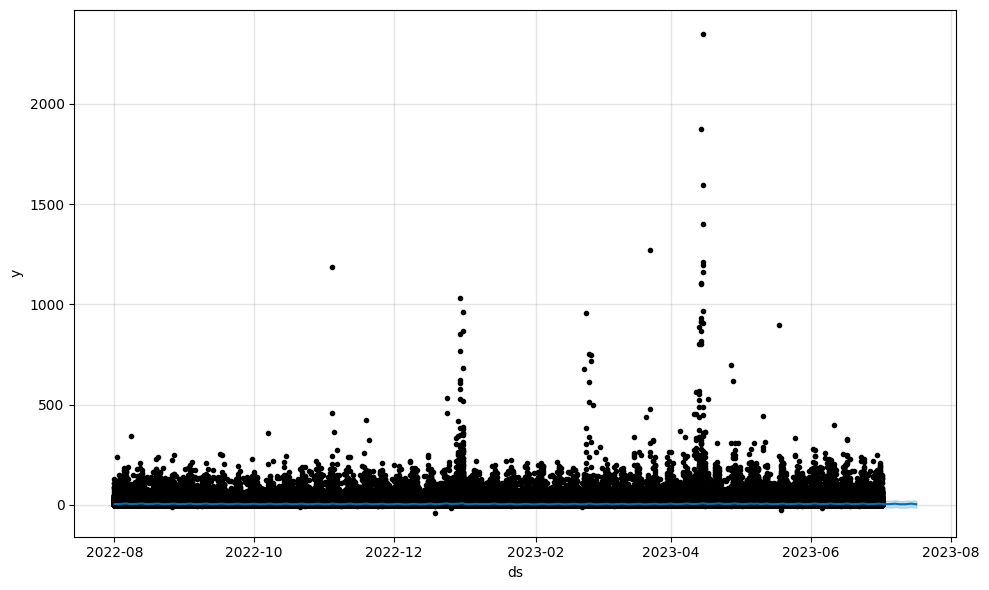

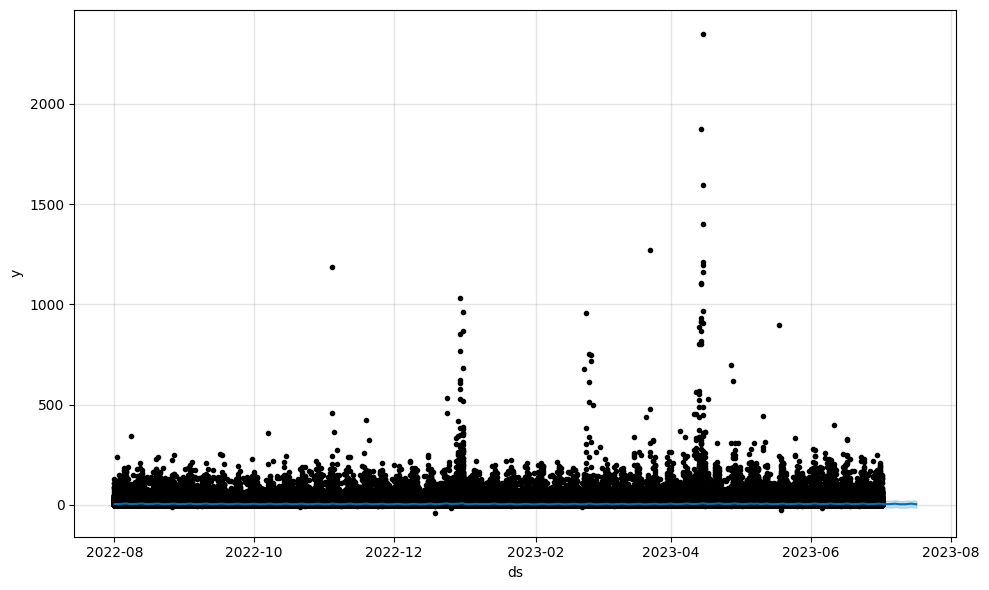

In [14]:
# Смотрим, что предсказалось
m.plot(forecast)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Lo

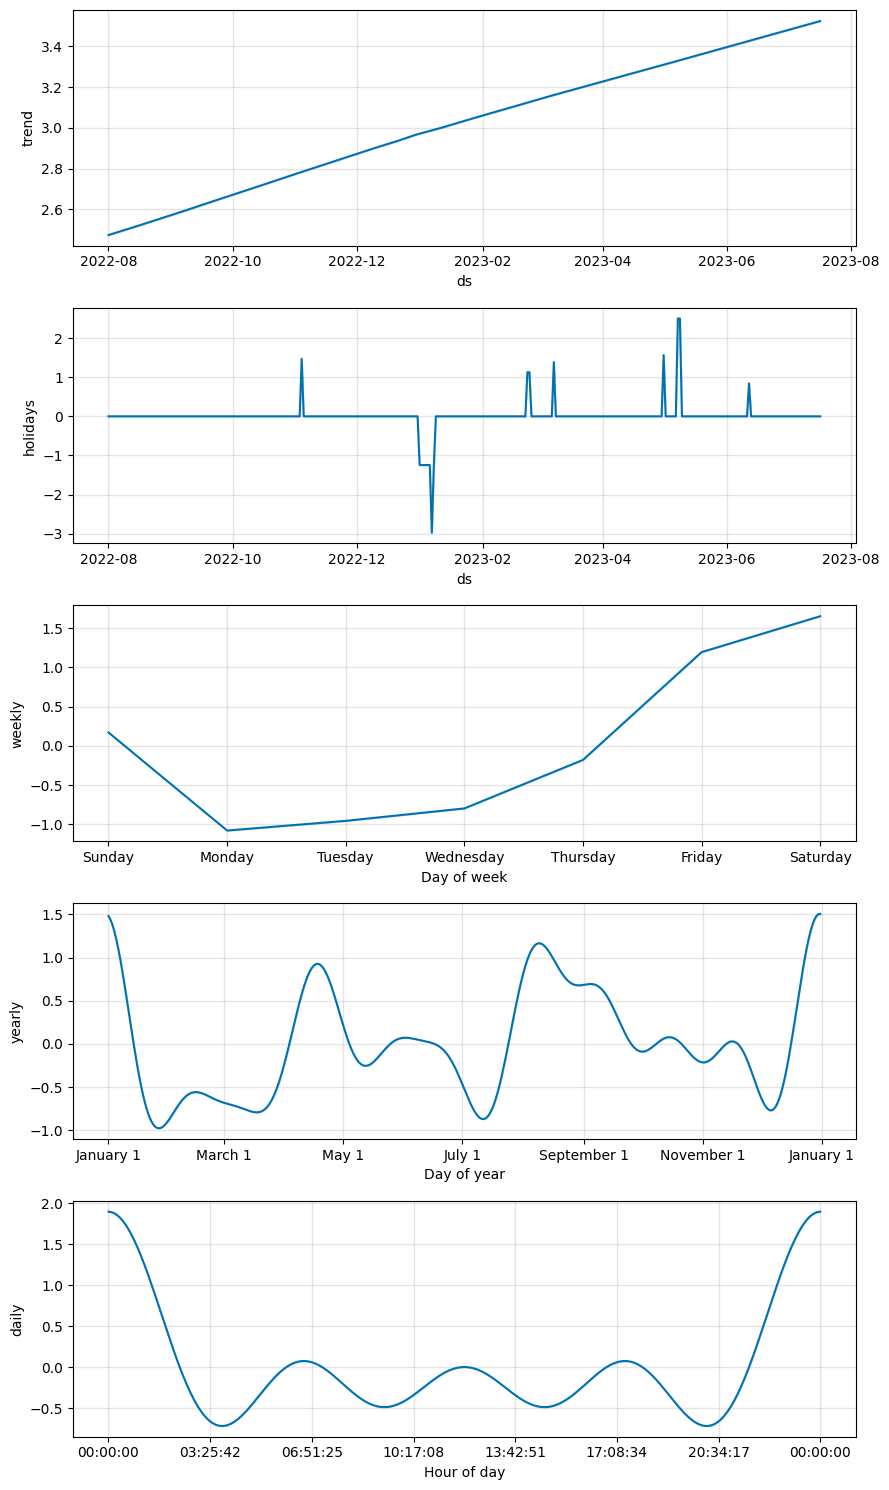

In [15]:
# Смотрим по компонентам
m.plot_components(forecast);

In [16]:
# Объединяем первоначальную таблицу и таблицу с признаками и таргетом
df_test = df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

In [17]:
# Для вычисления метрики берем только отрезанную часть датасета
df_metric = df_test[df_test['ds'] > predictions]

In [18]:
# Вычисляем метрику
wape = 100 * (df_metric['y'] - df_metric['yhat']).abs().sum() / df_metric['y'].sum()
wape

87.05557397536312

In [19]:
# функция для визуализации построенного прогноза
def show_forecast(cmp_df, num_predictions, num_values):
    # верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    # прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(df_test, predictions, 200)

NameError: name 'go' is not defined